In [33]:
! pip install pandas
! pip install matplotlib
! pip install seaborn

In [1]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

In [18]:
# Get a list of all log.txt files in the project directory



In [25]:
def directive(filename):
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('PROJECT_ID: '):
                value = line.split(':')[1].split('_')[0].strip()
                return value
    return None


In [29]:
import os
def load_data(df, machine):

    log_files = glob.glob(f'../results/{machine}/train/project/*/*.out')
    print("Output files found:", len(log_files))
    # Iterate over each log file
    for log_file in log_files:
        with open(log_file, 'r') as file:
            for line in file:
                if '# csv,timer' in line:
                    header = line.strip().split(',')
                elif '# csv,total' in line:
                    line = line.strip().split(',')
                    # Create a dictionary with keys from header and values from line
                    data_dict = dict(zip(header, line))
                    # Delete specified keys from the dictionary
                    del data_dict['uname.node']
                    del data_dict['user']
                    del data_dict['uname.system']
                    del data_dict['platform.version']
                    del data_dict['msg']
                    del data_dict['start']
                    del data_dict['sum']
                    del data_dict['# csv']
                    del data_dict['status']
                    del data_dict['timer']
                    data_dict["machine"] = machine
                    d = directive(log_file)
                    data_dict["directive"] = d
                    data_dict["kind"] = f"{machine}-{d}"
                    # Append data_dict to df
                    df = pd.concat([df, pd.DataFrame(data_dict, index=[0])], ignore_index=True)


    df['time'] = df['time'].astype(float)
    return df

# machines = 
results_dir = '../results'
machines = [os.path.basename(file) for file in os.listdir(results_dir)]

df = pd.DataFrame()

for machine in machines:
    df = load_data(df, machine)  

df

Output files found: 210


,time,tag,machine,directive,kind
0,11.149,small_lstm,rivanna,rtx2080,rivanna-rtx2080
1,11.336,small_lstm,rivanna,rtx2080,rivanna-rtx2080
2,11.206,small_lstm,rivanna,rtx2080,rivanna-rtx2080
3,69.523,large_tcnn,rivanna,rtx3090,rivanna-rtx3090
4,16.689,medium_cnn,rivanna,rtx2080,rivanna-rtx2080
...,...,...,...,...,...
205,9.558,small_lstm,rivanna,rtx3090,rivanna-rtx3090
206,9.874,small_lstm,rivanna,a100,rivanna-a100
207,9.832,small_lstm,rivanna,a100,rivanna-a100
208,9.538,small_lstm,rivanna,rtx3090,rivanna-rtx3090


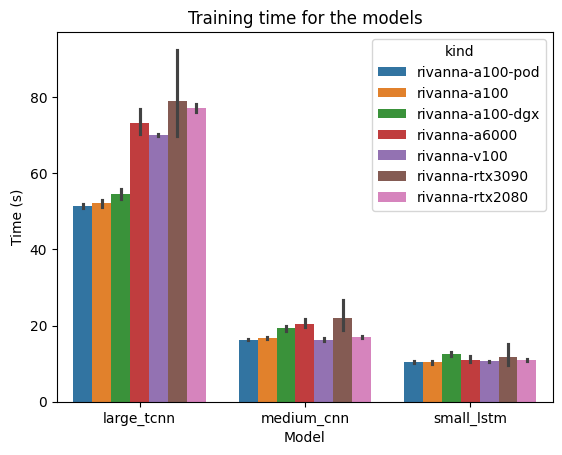

In [35]:
#df_sorted = df.sort_values('tag')
#sns.barplot(x=df_sorted['tag'], y=df_sorted['time'], hue=df_sorted['kind'])


df_sorted = df.sort_values(['tag', 'time'])
sns.barplot(x=df_sorted['tag'], y=df_sorted['time'], hue=df_sorted['kind'])


# Set the labels and title
plt.xlabel('Model')
plt.ylabel('Time (s)')
plt.title('Training time for the models')

# Set the y-axis to log scale
#plt.yscale('log')

# Set the y-axis formatter to display integers
#plt.gca().yaxis.set_major_formatter(plt.ScalarFormatter(useOffset=False))

# Show the plot
plt.show()
